In [1]:
import jax.numpy as np
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

import lineax
import jax
import optax
import optimistix

from make_pulse_and_trace import MakePulse, apply_noise

In [2]:
pulse_maker=MakePulse(N=128*12, Deltaf=3) # Deltaf should be 3 for thg and 2 for shg -> depends on central_f is guess, currently 0.5
# ifrog -> Deltaf controls temporal resolution and needs to be sufficiently large 


pulse_maker.multi_pulse_time_domain_length_multiplier=8
pulse_maker.multi_pulse_parameters=[[50, 50], [5, 5, 5], [0.5, 0.25, 0.25], [1, 1, 1], ["flat", "flat", "flat"], [None, None, None]] 

time_inp, pulse_t_inp, frequency_inp, pulse_f_inp=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.35, 0.1], type="polynomial", parameters_phase=[1/4,0,250,0], 
                                                                               multi_pulse_parameters=None)#pulse_maker.multi_pulse_parameters)

input_pulses=pulse_maker.input_pulses





time_gate, pulse_t_gate, frequency_gate, pulse_f_gate=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.45,0.05], type="polynomial", parameters_phase=[2/4,0,0,0], 
                                                                               multi_pulse_parameters=None)

input_pulses_gate=pulse_maker.input_pulses

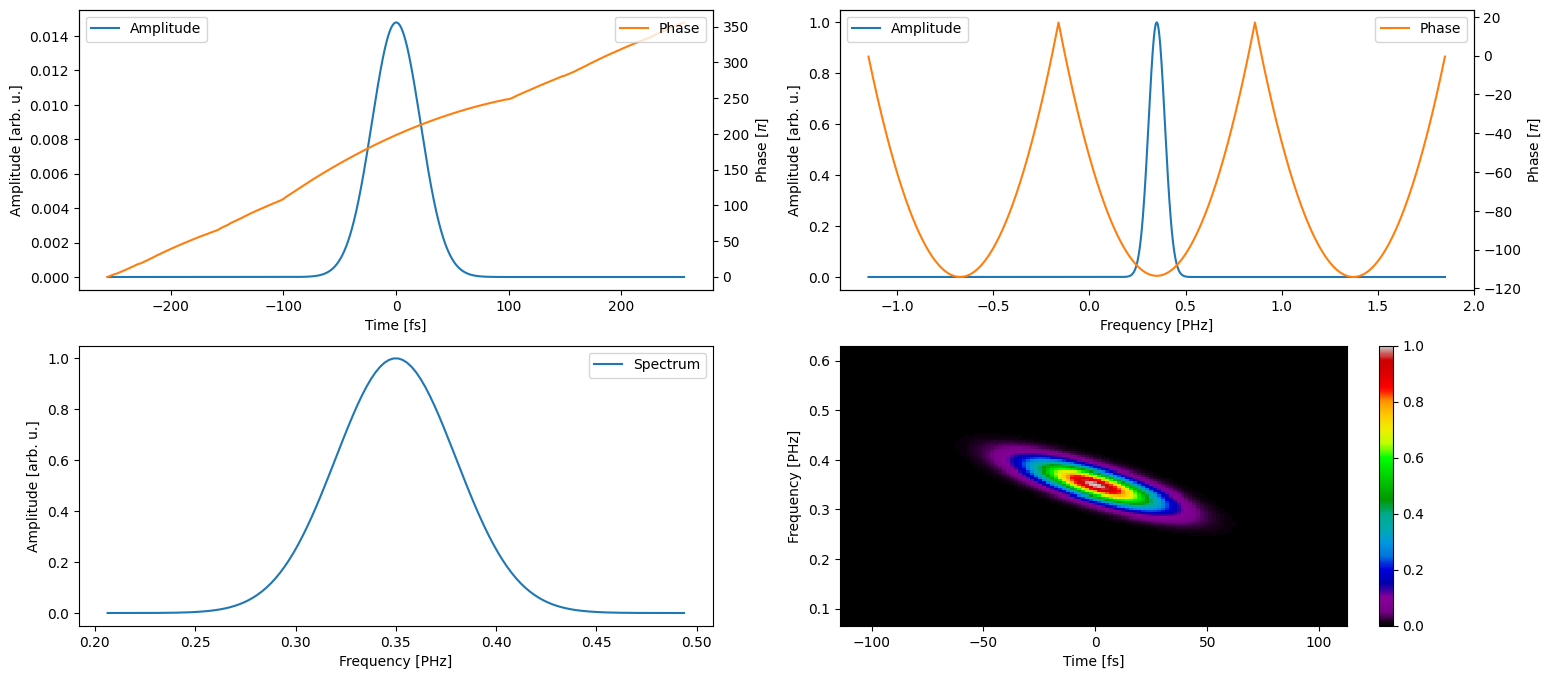

In [4]:
time, frequency, trace, frequency_spectrum, spectrum=pulse_maker.generate_frog_trace_and_spectrum(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, nonlinear_method="pg", 
                                                                                                  scale_time_range=2, N=128, xfrog=False, 
                                                                                                  gate=(frequency_gate, pulse_f_gate),
                                                                                                  interpolate_fft_conform=True, cut_off_val=1e-2,
                                                                                                  ifrog=False, frequency_range=None)#(0.1,1))

#trace = apply_noise(trace, scale_val=(0.05, 0.05), additive_noise=True, multiplicative_noise=True)

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


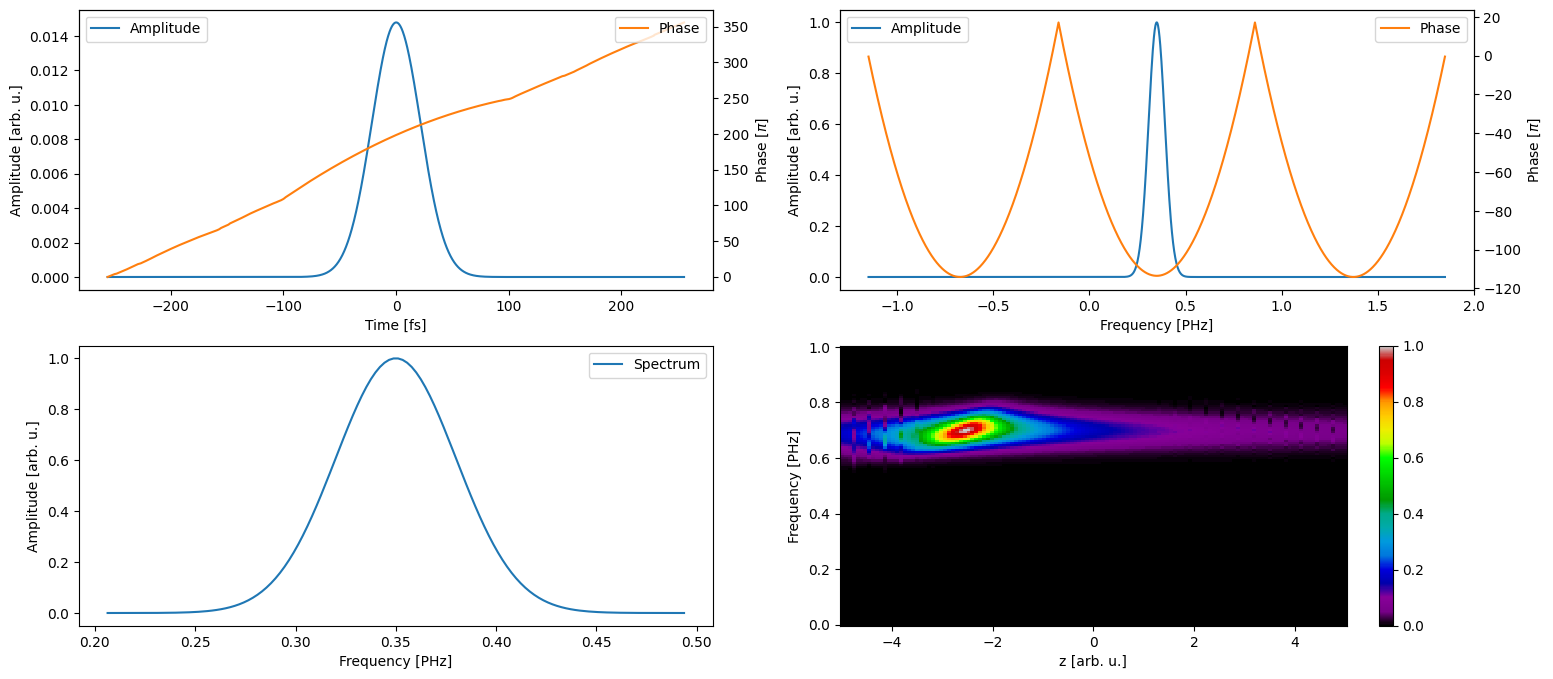

In [4]:
z_arr=np.linspace(-5, 5, 128)
#pulse_t, pulse_f=pulse_maker.precompensate_pulse_for_dscan(time, frequency, pulse_t, GDD=-5000, TOD=0, central_f=0.5)
frequency, trace, frequency_spectrum, spectrum=pulse_maker.generate_dscan_trace_and_spectrum(z_arr, time_inp, frequency_inp, pulse_t_inp, pulse_f_inp,
                                                                                                   nonlinear_method="shg", 
                                                                                                   N=128, cut_off_val=1e-4, frequency_range=(0,1))


#trace = apply_noise(trace, scale_val=0.01, additive_noise=True, multiplicative_noise=False)

# if there are weird stripes in the trace -> set Deltaf=2 somehow thats needed

In [4]:
from classic_algorithms_frog import Vanilla, LSGPA, GeneralizedProjection, TimeDomainPtychography, COPRA

this should be split such that everything happens inside initialize_local/global


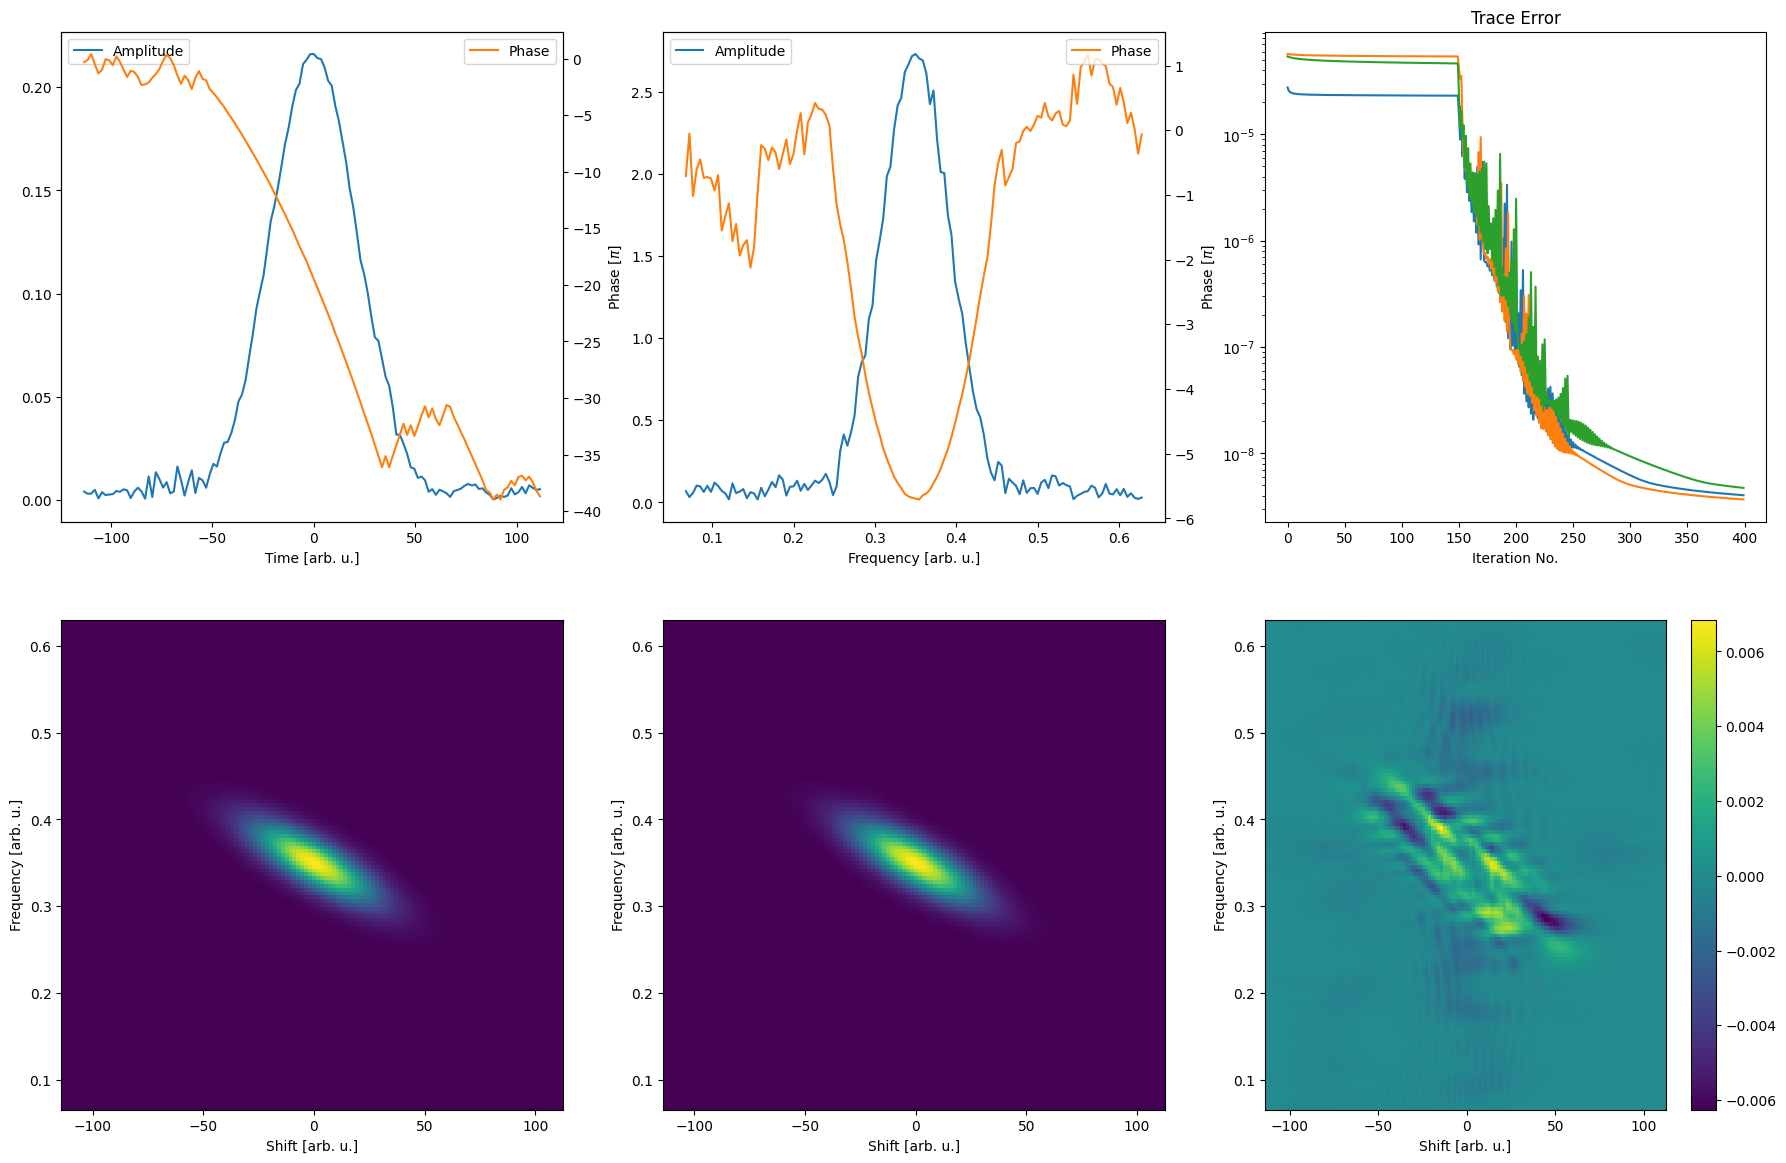

In [5]:
# vanilla = Vanilla(time, frequency, trace, "shg")
# population = vanilla.create_initial_population(population_size=3, guess_type="random")

# final_result = vanilla.run(population, 100)
# vanilla.plot_results(final_result)






# lsgpa = LSGPA(time, frequency, trace, "shg", xfrog="doubleblind")
# population = lsgpa.create_initial_population(population_size=3, guess_type="random")

# lsgpa.lambda_lm = 1e-3
# lsgpa.beta=0.1

# final_result = lsgpa.run(population, 5000)
# lsgpa.plot_results(final_result)






# gp = GeneralizedProjection(time, frequency, trace, "pg", xfrog="doubleblind")
# population = gp.create_initial_population(population_size=3, guess_type="random")

# gp.use_hessian = False#"lbfgs"


# gp.no_steps_descent = 25
# gp.max_steps_linesearch = 25
# gp.use_linesearch = "backtracking"
# gp.gamma = 1
# gp.delta_gamma = (0.5, 1.1)
# gp.c1 = 1e-4
# gp.c2 = 0.9

# gp.lbfgs_memory = 3

# gp.use_copra_style_step_scaling = False


# final_result = gp.run(population, 150)
# gp.plot_results(final_result)






# tdp = TimeDomainPtychography(time, frequency, trace, "pg", "rPIE", xfrog="doubleblind")
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# tdp.alpha=0.1
# tdp.beta=0.1
# tdp.gamma = tdp.beta

# tdp.use_global_step=False
# tdp.use_hessian="diagonal"

# final_result = tdp.run(population, 1500)
# tdp.plot_results(final_result)






copra = COPRA(time, frequency, trace, "pg", xfrog=False)#"doubleblind")
population = copra.create_initial_population(population_size=3, guess_type="random")
#copra.use_linesearch = "backtracking"
copra.beta=1e2
copra.xi=1e-6
final_result = copra.run(population, 150, 250)
copra.plot_results(final_result)


In [18]:
from utilities import MyNamespace, do_fft, calculate_trace, calculate_mu
from update_signal import calculate_S_prime_iterative_step, calculate_r_error, calculate_r_gradient
descent_state, measurement_info, descent_info = copra.descent_state, copra.measurement_info, copra.descent_info

signal_t = copra.generate_signal_t(descent_state, measurement_info, descent_info)
signal_t = signal_t.signal_t

r_err=[]
for i in range(500):
    sk, rn, measured_trace = measurement_info.sk, measurement_info.rn, measurement_info.measured_trace
    xi = descent_info.xi

    signal_f=do_fft(signal_t, sk, rn)
    trace=calculate_trace(signal_f)

    gradient = calculate_r_gradient(signal_f, measurement_info, descent_info)
    descent_direction = -1*gradient

    r_error = jax.vmap(calculate_r_error, in_axes=(0, None))(trace, measured_trace)
    eta = r_error/(jnp.sum(jnp.abs(descent_direction)**2, axis=(1, 2)) + xi)
    gamma = jnp.ones(descent_info.population_size)*descent_info.gamma
        
    signal_t_new = signal_t + gamma[:, jnp.newaxis, jnp.newaxis]*eta[:, jnp.newaxis, jnp.newaxis]*descent_direction



    print(jnp.sum(jnp.abs(signal_t)**2, axis=(1,2)),jnp.sum(jnp.abs(gamma[:, jnp.newaxis, jnp.newaxis]*eta[:, jnp.newaxis, jnp.newaxis]*descent_direction)**2, axis=(1,2)))




    signal_f = do_fft(signal_t_new, measurement_info.sk, measurement_info.rn)
    trace = calculate_trace(signal_f)
    error=jax.vmap(calculate_r_error, in_axes=(0,None))(trace, measurement_info.measured_trace)
    r_err.append(error)

    signal_t = signal_t_new

[0.0323499  0.0331579  0.03136807] [5.9946848e-05 5.0146529e-05 8.9020839e-05]
[0.03240977 0.03320804 0.03145709] [0.00936649 0.00775694 0.01533339]
[0.04177622 0.040965   0.0467905 ] [5.254588  3.8944907 8.896445 ]
[5.296365  3.9354556 8.943236 ] [ 9493.083  6436.242 11908.09 ]
[ 9498.38    6440.1772 11917.034 ] [ 0.359303  0.796239 14.840674]
[ 9498.739  6440.974 11931.875] [ 0.38018948  0.88117146 21.21678   ]
[ 9499.119  6441.855 11953.091] [ 0.4030371  0.9809296 32.518784 ]
[ 9499.5205  6442.836  11985.609 ] [ 0.42810822  1.0992347  54.46864   ]
[ 9499.95   6443.935 12040.078] [ 0.4557072  1.2410631 99.65329  ]
[ 9500.405  6445.176 12139.732] [  0.48619872   1.4131854  172.66602   ]
[ 9500.894  6446.59  12312.398] [  0.5200129   1.6250051 159.03386  ]
[ 9501.413  6448.215 12471.432] [ 0.557665   1.8898826 85.85087  ]
[ 9501.97   6450.104 12557.283] [ 0.5997765  2.2273257 53.47424  ]
[ 9502.569  6452.331 12610.757] [ 0.6471014  2.6666703 37.01261  ]
[ 9503.216  6454.998 12647.769] 

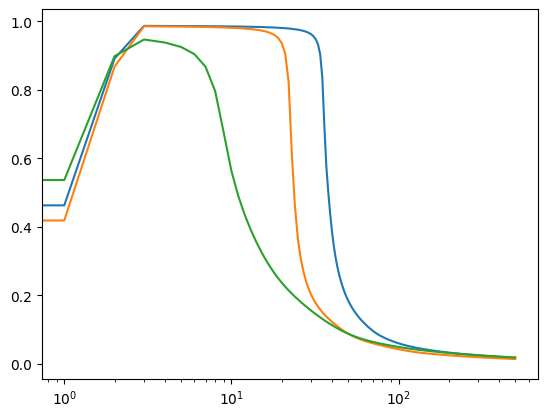

In [22]:
plt.plot(r_err)
plt.xscale("log")

In [4]:
from classic_algorithms_dscan import Basic, GeneralizedProjection, TimeDomainPtychography, COPRA

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:297: RuntimeWarning: invalid value encountered in divide
  g = lambda c1, c2, w: c1 * (w ** 2) / (w ** 2 - c2 ** 2)
/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


this is not necessary if all error_arrs are treated correctly


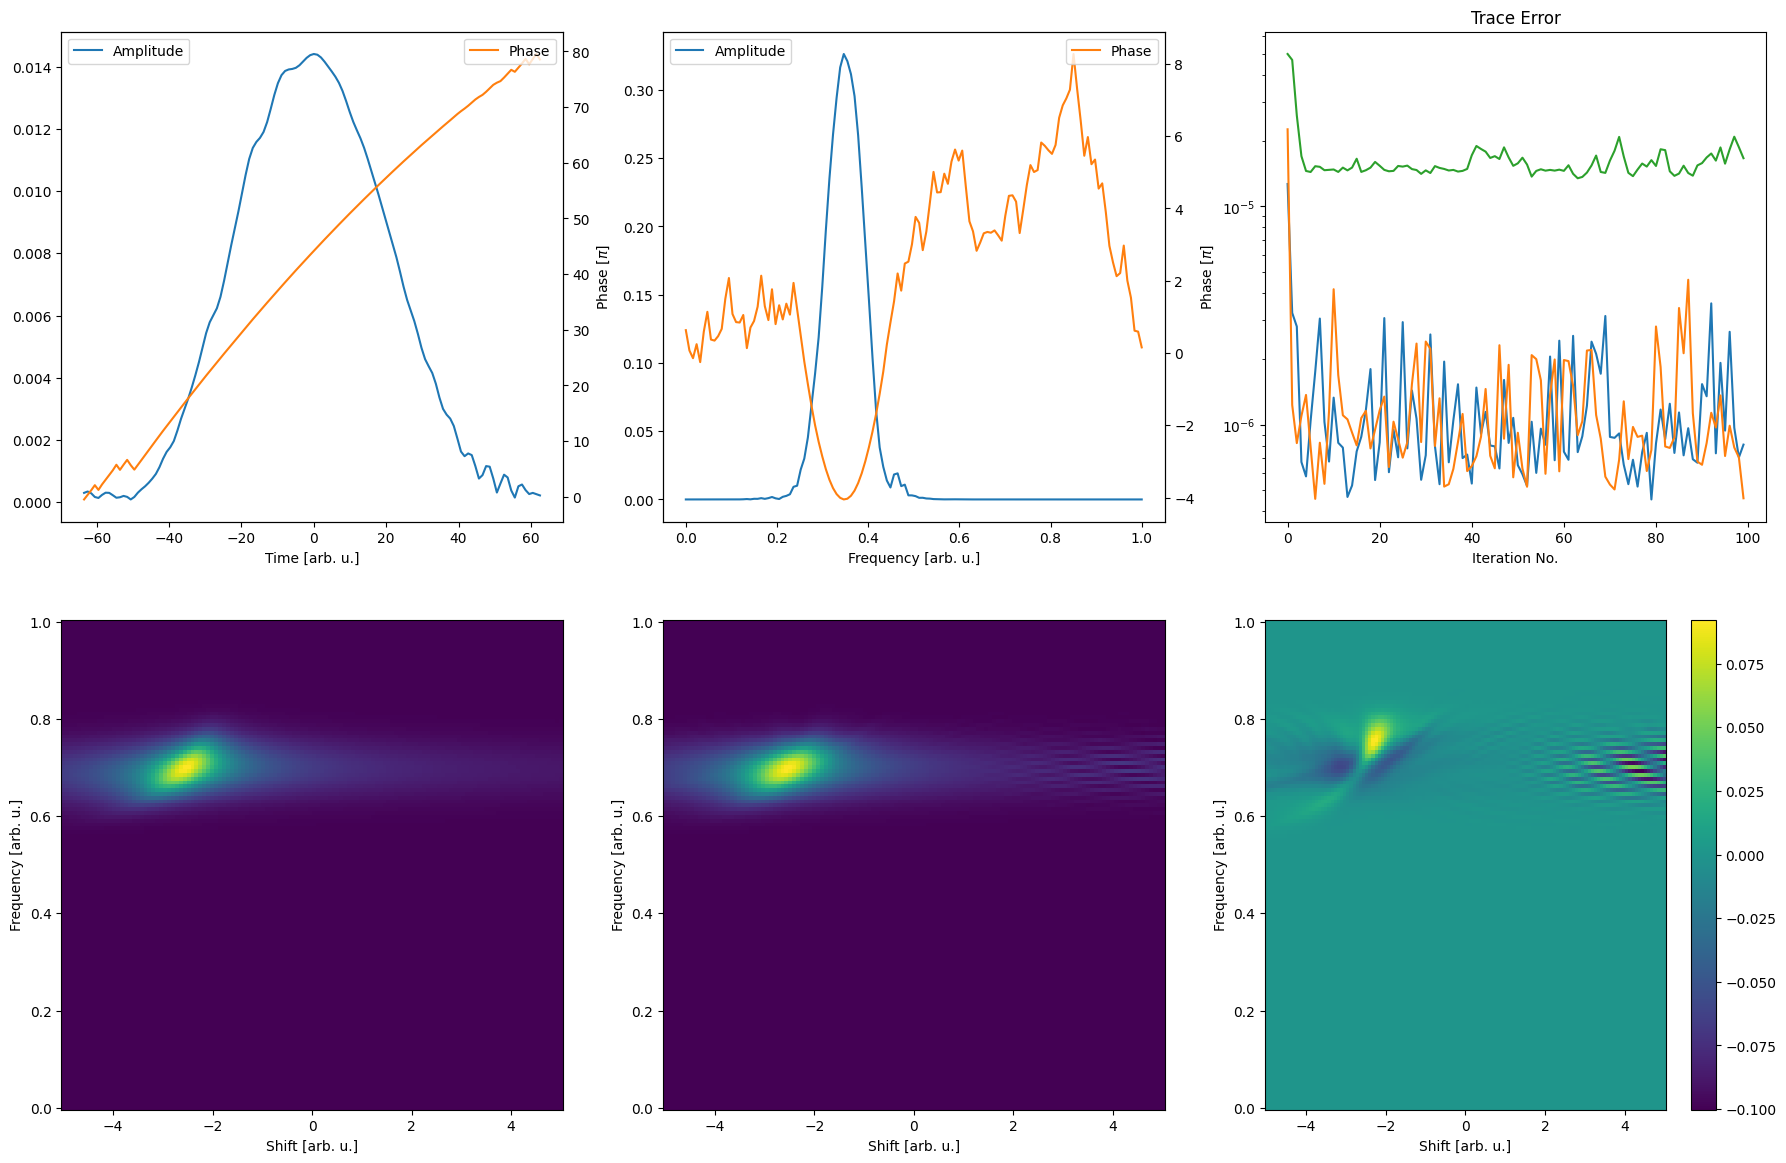

In [ ]:
# basic = Basic(z_arr, frequency, trace, "shg")
# population = basic.create_initial_population(population_size=3, guess_type="random")

# final_result = basic.run(population, 100)
# basic.plot_results(final_result)





# gp = GeneralizedProjection(z_arr, frequency, trace, "shg")
# population = gp.create_initial_population(population_size=3, guess_type="random")

# gp.no_steps_gradient_descent=50
# gp.gamma=1e2

# final_result = gp.run(population, 100)
# gp.plot_results(final_result)




# tdp = TimeDomainPtychography(z_arr, frequency, trace, "shg", PIE_method="ePIE")
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# tdp.alpha=0.1
# tdp.beta=0.1

# tdp.wolfe_linesearch=False

# tdp.use_global_step=True
# tdp.use_hessian="diagonal"

# final_result = tdp.run(population, 100)
# tdp.plot_results(final_result)






# copra = COPRA(z_arr, frequency, trace, "shg")
# population = copra.create_initial_population(population_size=3, guess_type="random")

# copra.beta = 1e1
# copra.alpha = 1e1
# copra.use_hessian = False, "diagonal"

# final_result = copra.run(population, 50, 200)
# copra.plot_results(final_result)

In [5]:
from general_algorithms_frog import DifferentialEvolution, Evosax, LSF, AutoGrad

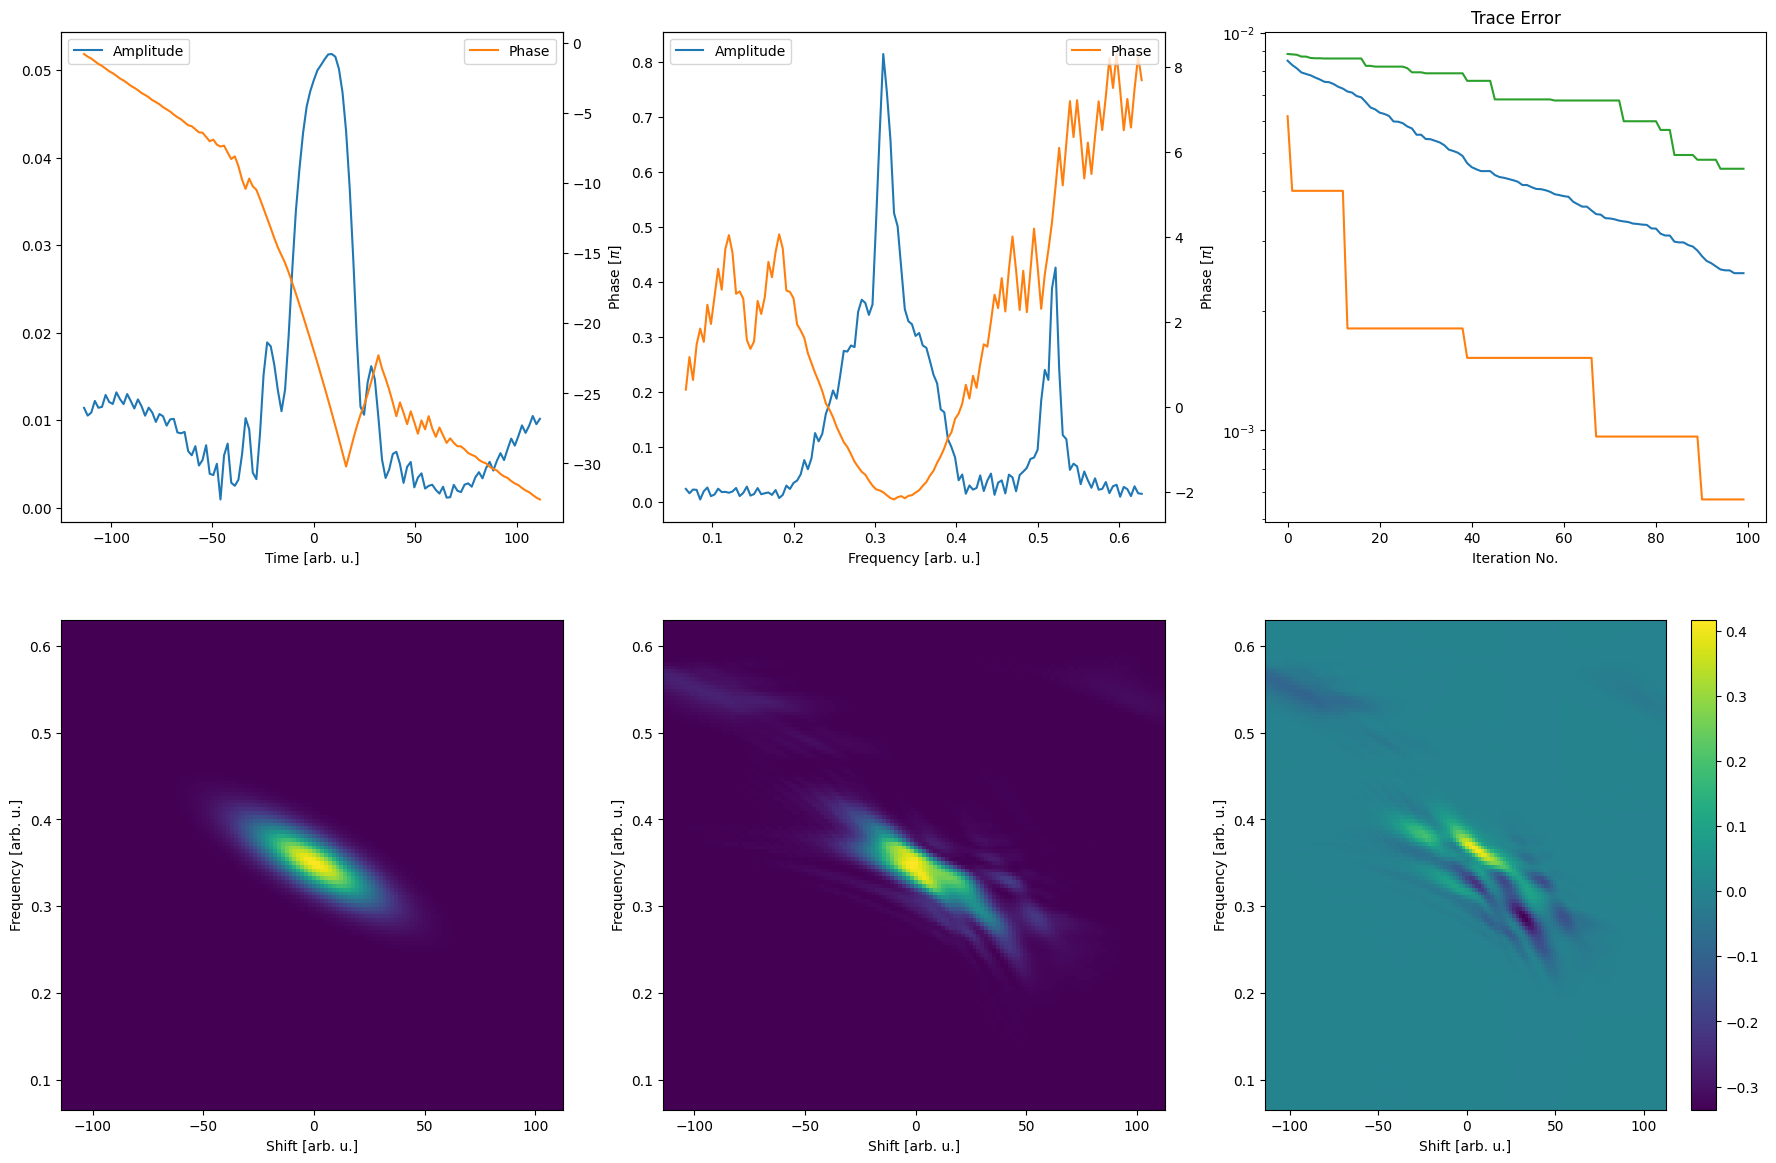

In [ ]:
# de = DifferentialEvolution(time, frequency, trace, "shg", xfrog="doubleblind")
# population = de.create_initial_population(population_size=50)

# final_result = de.run(population, 100)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(time, frequency, trace, "shg", xfrog=False)
# evo.solver = CMA_ES
# population = evo.create_initial_population(population_size=250)

# final_result = evo.run(population, 100)
# evo.plot_results(final_result)




# lsf = LSF(time, frequency, trace, "shg", xfrog=False)
# population = lsf.create_initial_population(population_size=3, amp_type="discrete", phase_type="discrete")

# lsf.number_of_bisection_iterations=12
# lsf.random_direction_mode="random"
# lsf.no_points_for_continuous=15

# final_result = lsf.run(population, 1000)
# lsf.plot_results(final_result)





# ad = AutoGrad(time, frequency, trace, "shg", xfrog="doubleblind")
# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")


# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)

In [4]:
from general_algorithms_dscan import DifferentialEvolution, Evosax, LSF, AutoGrad

this is not necessary if all error_arrs are treated correctly


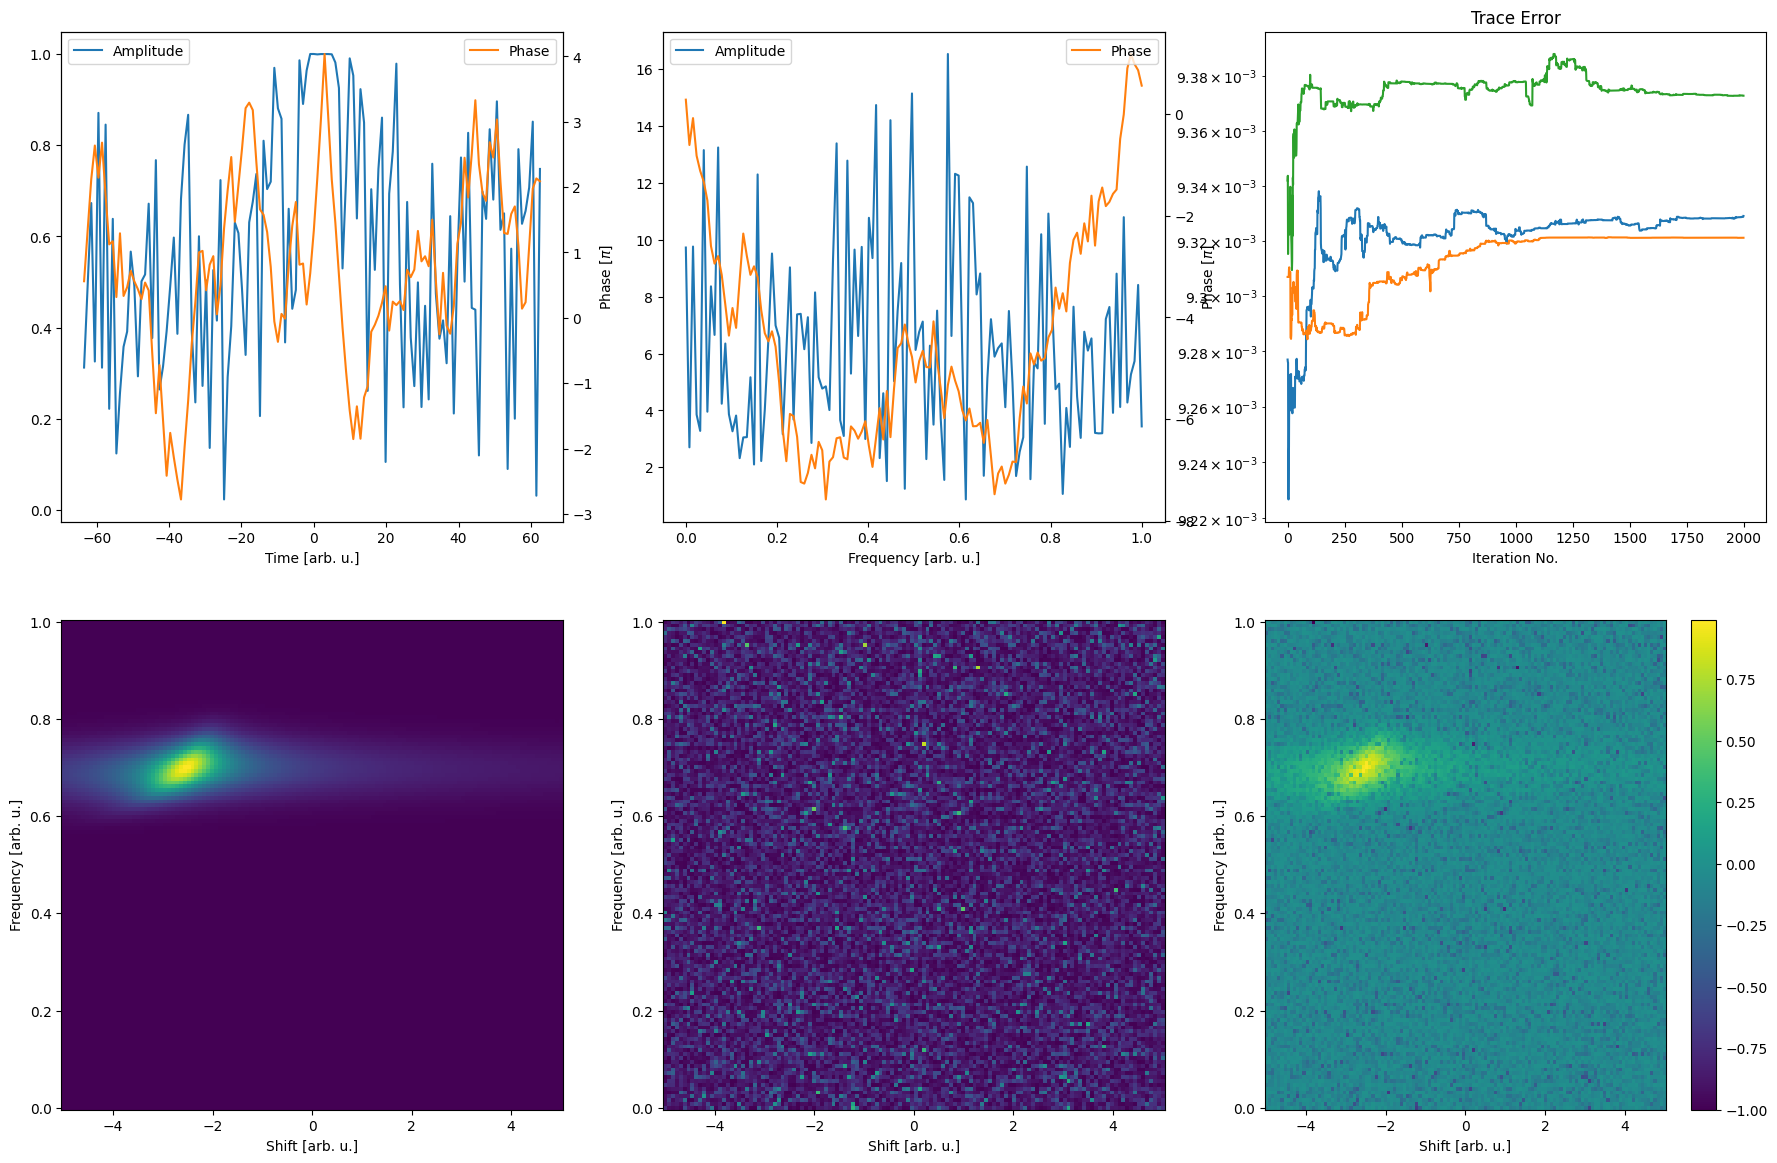

In [7]:
# de = DifferentialEvolution(z_arr, frequency, trace, "shg")
# population = de.create_initial_population(population_size=150)

# final_result = de.run(population, 100)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(z_arr, frequency, trace, "shg")
# evo.solver = CMA_ES
# population = evo.create_initial_population(population_size=250)

# final_result = evo.run(population, 100)
# evo.plot_results(final_result)




lsf = LSF(z_arr, frequency, trace, "shg")
population = lsf.create_initial_population(population_size=3, amp_type="random", phase_type="random")

lsf.number_of_bisection_iterations=8
lsf.random_direction_mode="random"
lsf.no_points_for_continuous=15

final_result = lsf.run(population, 2000)
lsf.plot_results(final_result)





# ad = AutoGrad(z_arr, frequency, trace, "shg")
# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.solver=optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)